# <span style="color:blue;"> SISMID Module 9: Lab 5 </span>
    
## <span style="color:blue;"> Contact Tracing </span>

#### <span style="color:blue;"> Joel Miller, Tom Hladish, Shweta Bansal

## Student name: [Callum Arnold]

#### Date: July 16, 2021 (Session 3D)

An important tool for controling infectious disease is contact tracing.  This is particularly important in cases where an individual may be infectious without showing symptoms.  Many sexually transmitted diseases exhibit this pattern, but more significantly at the moment, COVID-19 has this property.

Consider an infectious disease in which some individuals may transmit to their contacts even without showing symptoms.

We will look at three scenarios.  
- The first scenario is a basic SIR epidemic, where the course of an infection is $S \to I \to R$.  
- In the second scenario, individuals are infectious prior to symptom onset.  The course of an infection is $S\to E  \to I \to R$ where both the $E$ and $I$ stage are infectious, but the $E$ stage is asymptomatic (or "presymptomatic").
- In the third scenario, some fraction of individuals are infectious but never become symptomatic.  Here the individuals pass through one of two paths: $S \to I_1 \to R$  or $S \to I_2 \to R$ where the $I_1$ state is asymptomatic and the $I_2$ stage is symptomatic.

To investigate these, we will use stochastic simulation using the `EoN` python package.  We will work through an example for an $SIR$ epidemic without tracing.  Then we will add tracing to it.  After that, we will explore transmission from nodes that do not have symptoms.  

`EoN` has built in tools for stochastic simulation of SIS and SIR epidemics.  However, they do not account for contact tracing.  Instead we will use a more flexible tool that runs slower, but allows us to include more complicated processes.


The term "simple contagion" refers to a contagious process where two types of transitions happen:
- transitions induced by a single neighbor, such as the $S \to I$ transition in the SIS or SIR model or the $S \to E$ transition in the SEIR model.
- transitions induced by processes internal to the node such as the $I \to R$ transition in the SIR model, the $I \to S$ transition in the SIS model, or the $E \to I$ transition in the model with presymptomatic transmission described above.

`EoN` has a method `EoN.Gillespie_simple_contagion` which can simulate simple contagions.  However, we need to encode the status changes somehow.  We give an example below for how to encode an SIR simulation with it.  There are more examples  given in the `EoN` [documentation for `Gillespie_simple_contagion`](https://epidemicsonnetworks.readthedocs.io/en/latest/Examples.html#non-sis-sir-processes-with-gillespie-simple-contagion) (and `EoN` has faster tools that specialize to simulating SIR epidemics).



## 1. Contact tracing in an SIR epidemic:

To use `EoN`'s simple contagion tool, we'll initially focus on an SIR epidemic, starting without the contact tracing.

First we build a contact network and encode the transmission/recovery parameters $\gamma$ and $\beta$.  We set $\gamma=1$ and $\beta = 0.5$.

In [1]:
import EoN
import networkx as nx
import matplotlib.pyplot as plt

gamma = 1 #I->R transition rate

beta = 0.5 #transmission rate from I


G=nx.configuration_model([5]*1000) # a random 1000 node graph with all nodes having degree 5.
G = nx.Graph(G)  #this turns the "MultiGraph" which could have repeated edges into a "Graph" with no repeated edges
G.remove_edges_from(nx.selfloop_edges(G)) #self-loops cause trouble for the simple_contagion algorithm.  
#There may be a couple, so we remove them.

Now we need to encode the transitions.  An infected node can transmit to a susceptible neighbor, or a infected node can recover (without interaction with any other nodes).  Here is a graphical display of the transitions that can occur:

<img src="SIR_transitions.png" style="width: 375px" style="float: center;">

Notice that we can look at this like two directed graphs.  One graph has nodes which represent possible statuses ($I$) and ($R$) with an edge from $I$ to $R$, while the other graph has nodes which represent pairs ($I$--$S$) and ($I$--$I$).

For the SIR epidemic the only "internal" transition is $I \to R$.  We can represent this by a directed graph $H$ which consists of a single edge from $I$ to $R$.  This occurs with rate $\gamma$.

The only "neighbor-induced" transition occurs when one node in an edge has status $I$ and the other has status $S$.  In this case we see $(I,S) \to (I,I)$.  We can represent this by a directed graph $J$ which consists of a two nodes, $(I,S)$ and $(I,I)$, with an edge from $(I,S)$ to $(I,I)$.  This occurs with rate $\beta$.  Note that we put the status that changes second in the pairs and the status that remains the same does not change.

The `Gillespie_simple_contagion` algorithm provided by `EoN` needs these two directed graphs.  Once it has them, and the initial condition of all nodes, it will simulate the epidemic.


In [2]:
H = nx.DiGraph()  #a (initially empty) Directed Graph that will store internal transitions

H.add_edge('I', 'R', rate = gamma)

J = nx.DiGraph()
J.add_edge(('I', 'S'), ('I', 'I'), rate = beta) #this is a 2-node graph whose nodes do not represent a contact network.

# The nodes represent an IS pair and an II pair, and the edge with the assigned
# rate represents the fract that when the transmission happens (which has rate
# beta)the IS pair becomes an II pair.
 

Once we have the two directed graphs, we can do the simulation.

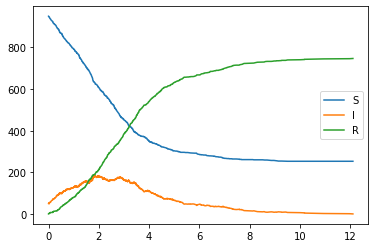

In [3]:
return_statuses = ('S', 'I', 'R')  #This tells the simple contagion algorithm what data to return and in what order.

IC = {}
for node in G.nodes():   #there are other ways to initialize this, but they use more advanced data structures.  We'll keep it simple.
    if node<50:
        IC[node] = 'I'
    else:
        IC[node] = 'S'

t, S, I, R = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = float('Inf'))
#The returned array t gives every single time that something happens in the simulation.  the other arrays S, I, and R give the number of nodes of each status at each of those times.

plt.plot(t,S, label='S')
plt.plot(t,I, label='I')
plt.plot(t,R, label='R')
plt.legend()
plt.show()

Now we add contact tracing to this model.  We will add two statuses.  
- Nodes may have status $T$ if they have been identified as infected and their neighbors are being traced.  We assume $T$ nodes are not infectious.
- Nodes may have status $X$ if they were identified as infected, but their neighbors are no longer being traced.  These nodes may still be sick or not.

There are two ways a node can enter status $T$.  An infected node can be tested because of symptoms and identified through that.  Or an infected node can be tested because one of its neighbors is in status $T$.  We assume this occurs with rate $\sigma_T = 1$.

A node in $T$ can transition to $X$.  We assume this occurs with rate $\gamma_T=0.5$

In the exercises below, we add contact tracing to the SIR model above.
#### <span style="color:orange;"> Ex 1.1 Add an edge to the directed graph `H` representing the $I$ to $T$ transition due to symptomatic individuals being tested.  Also add an edge representing the $T$ to $X$ transition.

In [4]:
sigma_T = 1
gamma_T = 0.5

H.add_edge("I", "T", rate = sigma_T)
H.add_edge("T", "X", rate = gamma_T)
H.edges()

OutEdgeView([('I', 'R'), ('I', 'T'), ('T', 'X')])

#### <span style="color:orange;"> Ex 1.2 Add an edge to the directed graph `J` representing the $I$ to $T$ transition due to an infected individual being identified through tracing.

In [5]:
J.clear_edges()
J.add_edge(('I', 'S'), ('I', 'I'), rate = beta)
J.add_edge(('I', 'I'), ("I", "T"), rate = sigma_T)
J.edges()

OutEdgeView([(('I', 'S'), ('I', 'I')), (('I', 'I'), ('I', 'T'))])

#### <span style="color:orange;"> Ex 1.3 Get `EoN.Gillespie_simple_contagion` to return all of the statuses $S$, $I$, $R$, $T$, and $X$.  Plot the curves.

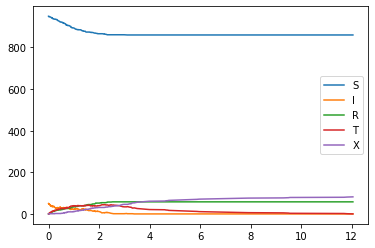

In [6]:
return_statuses = ('S', 'I', 'R', "T", "X")
t, S, I, R, T, X = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = float('Inf'))
#The returned array t gives every single time that something happens in the simulation.  the other arrays S, I, and R give the number of nodes of each status at each of those times.

plt.plot(t,S, label='S')
plt.plot(t,I, label='I')
plt.plot(t,R, label='R')
plt.plot(t,T, label = "T")
plt.plot(t, X, label = "X")
plt.legend()
plt.show()

## 2. Presymptomatic transmission

Now we consider a modified model.  COVID-19 is more difficult to control because infected individuals are often infectious prior to being symptomatic.  For this, we consider a model with structure $S I_1 I_2 R$ where $S$ nodes become infected and enter the state $I_1$.  

In $I_1$ they are infectious (and transmit to neighbors at rate $\beta_1=0.5$), but they have no symptoms.  They can only be identified through contact tracing.  At rate $\sigma=2$ they enter the state $I_2$.  

Once they are in $I_2$, they display symptoms and recover to $R$ with rate $\gamma=2$.  The $I_2$ stage is infectious (and transmits to neighbors at rate $\beta_2=0.5$).  It is possible for a node in $I_2$ to be identified through testing due to symptoms, which occurs with rate $\alpha_T=0.25$.  

Once an individual has status $T$, its $I_1$ or $I_2$ neighbors are identified at rate $\delta_T=1$ and they transition into $T$.

Nodes move from $T$ to $X$ with rate $\gamma_T = 0.5$.

The following exercises are somewhat open-ended, and involve 

#### <span style="color:orange;"> Ex 2.1 Create a new simulation with the states $S$, $I_1$, $I_2$, $R$, $T$, and $X$.

In [17]:
# A: create graph to simulate on
A = nx.configuration_model([5]*1000)         # a random 1000 node graph with all nodes having degree 5.
A = nx.Graph(A)                              # this turns the "MultiGraph" which could have repeated edges into a "Graph" with no repeated edges
A.remove_edges_from(nx.selfloop_edges(A))    # self-loops cause trouble for the simple_contagion algorithm; there may be a couple, so we remove them.

In [18]:
sigma = 2 # Pre-symptomatic to symptomatic infection
gamma = 2 # Recovery rate
beta_1 = 0.5 # Pre-symptomatic transmission prob
beta_2 = 0.5 # Symptomatic transmission prob
alpha_T = 0.25 # Symptomatic identification rate
delta_T = 1 # Symptomatic node's neighbor identification rate
gamma_T = 0.5 # Tested neighbors not followed rate

B = nx.DiGraph()  #a (initially empty) Directed Graph that will store internal transitions
B.add_edge('I_1', 'I_2', rate = sigma)
B.add_edge('I_2', 'R', rate = gamma)
B.add_edge("I_2", "T", rate = alpha_T)
B.add_edge("T", "X", rate = gamma_T)
print(B.edges())

C = nx.DiGraph()
C.add_edge(('I_1', 'S'), ('I_1', 'I_1'), rate = beta_1)
C.add_edge(('I_2', 'S'), ('I_2', 'I_1'), rate = beta_2)
C.add_edge(("T", "I_1"), ("T", "T"), rate = delta_T)
C.add_edge(("T", "I_2"), ("T", "T"), rate = delta_T)
print(C.edges())

return_statuses = ('S', 'I_1', "I_2", 'R', "T", "X")

[('I_1', 'I_2'), ('I_2', 'R'), ('I_2', 'T'), ('T', 'X')]
[(('I_1', 'S'), ('I_1', 'I_1')), (('I_2', 'S'), ('I_2', 'I_1')), (('T', 'I_1'), ('T', 'T')), (('T', 'I_2'), ('T', 'T'))]


In [21]:
IC = {}    # initial conditions (IC)
for node in A.nodes():   # there are more efficient ways to initialize this, using a `defaultdict`
    if node<50:
        IC[node] = 'I_1'
    else:
        IC[node] = 'S'

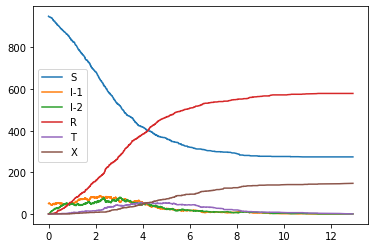

In [22]:
t, S, I_1, I_2, R, T, X = EoN.Gillespie_simple_contagion(A, B, C, IC, return_statuses, tmax = float('Inf'))
#The returned array t gives every single time that something happens in the simulation.  the other arrays S, I, and R give the number of nodes of each status at each of those times.

plt.plot(t,S, label='S')
plt.plot(t,I_1, label='I-1')
plt.plot(t,I_2, label='I-2')
plt.plot(t,R, label='R')
plt.plot(t,T, label = "T")
plt.plot(t, X, label = "X")
plt.legend()
plt.show()

#### <span style="color:orange;"> Ex 2.2 Explore the tradeoff with effort to increase contact tracing versus increase testing to find $I$ nodes.

#### <span style="color:orange;"> Ex 2.3  How does the total number of infections at the end of the epidemic ($1-S$) vary as contact tracing rates change or testing rates change?


#### <span style="color:orange;"> Ex 2.4 What happens if the testing rate gets too low?  Can you explain the mechanism for why this happens?

#### <span style="color:orange;"> Ex 2.5 What happens as the relative infectiousness of the `I_1` or `I_2` statuses vary?

## 3. Further extensions:

There are many ways you could extend these models and explore interesting, important questions.  For example,

#### <span style="color:orange;"> Ex 3.1 What happens if instead of nodes going from a presymptomatic stage to a symptomatic stage ($S\to I_1 \to I_2 \to R$), infected individuals either move to an infected but asymptomatic class or an infected but symptomatic class ($S \to I_1 \to R$ **or** $S \to I_2 \to R$)?



#### <span style="color:orange;"> Ex 3.2 How might you model a delay between a test and receiving results?
